# 📈 Stock Price Prediction using ARIMA, LSTM, and Bayesian-Optimized LSTM with Google Trends Integration

## 🎯 Objective of the Study

The primary objective of this study is to investigate the effectiveness of traditional and deep learning models in predicting stock prices using historical OHLC (Open, High, Low, Close) data, and to assess whether augmenting these models with external macro-behavioral indicators—specifically Google Trends data—can enhance prediction accuracy.

This project explores and compares the performance of:
- **ARIMA** (Auto-Regressive Integrated Moving Average): a classical statistical model for time series forecasting.
- **LSTM** (Long Short-Term Memory): a deep learning model well-suited for sequence prediction.
- **Bayesian-Optimized LSTM**: an LSTM model whose architecture and hyperparameters are optimized using Bayesian methods to improve forecasting performance.

---

## 📊 Description of the Data

### 1. OHLC Data
- Daily historical stock prices obtained from financial APIs (e.g., Yahoo Finance).
- Features include:
  - `Open`: The price at which the stock opened for trading.
  - `High`: The highest price reached during the trading day.
  - `Low`: The lowest price reached during the trading day.
  - `Close`: The final trading price at market close.
  - `Volume`: The number of shares traded.

### 2. Google Trends Data
- Search interest data collected using the **Google Trends API** via the `pytrends` Python library.
- Keyword(s) related to the selected stock or company (e.g., "Apple stock", "Tesla share price").
- Provides normalized search interest over time (0–100 scale), reflecting public attention or sentiment.

---

## 🔍 Hypotheses

This study is grounded in the hypothesis that **public attention, as captured by Google search volumes, correlates with stock market dynamics**. Specifically, we propose:

1. **Hypothesis 1**: An increase in Google search frequency for a stock/company precedes higher trading volume and volatility, indicating predictive potential.

2. **Hypothesis 2**: Google Trends data improves short-term forecasting accuracy when combined with OHLC inputs, especially for LSTM-based models.

3. **Hypothesis 3**: During periods of market uncertainty (e.g., earnings reports, global events), the impact of Google Trends on price prediction is more pronounced.

4. **Hypothesis 4**: Trend spikes without corresponding price movements can act as contrarian signals, potentially useful in hybrid trading strategies.

*More hypotheses and in-depth analysis will be added as the project evolves.*

---

📌 *Note: This project does not constitute financial advice. It is conducted solely for research and educational purposes.*


# 🛠️ Setup and Imports

In this section, we import all the necessary Python libraries required for:

- Data collection (e.g., stock prices and Google Trends)
- Data manipulation and visualization
- Time series analysis and modeling (ARIMA, LSTM)
- Deep learning and Bayesian optimization
- Evaluation and metrics

Ensure that all dependencies are installed in your Python environment before proceeding.

In [1]:
!pip install pytrends

In [2]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [3]:
# Data Handling and Manipulation
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import re
import time

# Data Collection
import yfinance as yf
from pytrends.request import TrendReq

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Statistical Tests & Time Series Analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Deep Learning: LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Bayesian Optimization for LSTM
import keras_tuner as kt

# Utilities
import warnings
warnings.filterwarnings("ignore")

# Interactive Display
from IPython.display import display, Markdown

# 📥 Data Collection

In this section, we define a modular and extensible Python class to handle the data collection process for this project.

The class will include functions to:
- Fetch historical stock market OHLC data using `yfinance`
- Retrieve Google Trends data using `pytrends` (to be added later)
- Preprocess and merge datasets into a unified format

We begin by implementing the method for collecting **daily OHLC stock price data** given a stock ticker and a date range.

In [4]:
class MarketDataCollector:
    def __init__(self):
        self.pytrends = TrendReq(hl='en-US', tz=360)
        self.GT_cooldown = 3

    def fetch_ohlc_data(self, ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
        print(f"Fetching OHLC data for {ticker} from {start_date} to {end_date}...")
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
            # Show what's coming in
            print(f"Raw OHLC columns: {data.columns.tolist()}")

            if isinstance(data.columns, pd.MultiIndex):
                # Only use the first level (like 'Close') to simplify
                data.columns = [col[0].lower().strip() for col in data.columns.values]
            else:
                data.columns = [str(col).lower().strip() for col in data.columns]

            required_cols = ['open', 'high', 'low', 'close', 'volume']
            available_cols = [col for col in required_cols if col in data.columns]
            data = data[available_cols]
            data.dropna(inplace=True)
            data.index.name = "Date"
            print(f"OHLC data shape: {data.shape}")
            print(data)
            return data
        except Exception as e:
            print(f"Error fetching OHLC data: {e}")
            return pd.DataFrame()

    def fetch_google_trend(self, keyword: str, start_date: str, end_date: str, ticker: str = "TICKER") -> pd.DataFrame:
        """
        Fetches Google Trends data for a keyword between start_date and end_date.
        - If existing CSV contains the full date range, it loads from that.
        - Else, splits into <=85-day chunks, retries on rate-limiting (429), and saves merged result.
        """
        os.makedirs("googleTrend", exist_ok=True)

        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)

        # 🔍 Check for existing file that contains full requested range
        matching_file = None
        one_word_keyword = keyword.replace(" ", "_")
        pattern = re.compile(rf"{one_word_keyword}_GT_(\d{{8}})_(\d{{8}})\.csv")

        for fname in os.listdir("googleTrend"):
            match = pattern.match(fname)
            if match:
                file_start = pd.to_datetime(match.group(1))
                file_end = pd.to_datetime(match.group(2))
                if file_start <= start_dt and end_dt <= file_end:
                    matching_file = f"googleTrend/{fname}"
                    break

        if matching_file:
            print(f"Found existing trend data containing full range. Loading from file: {matching_file}")
            trend_data = pd.read_csv(matching_file, index_col="Date", parse_dates=True)
            return trend_data.loc[start_dt:end_dt]

        print(f"🔍 No existing file contains the full range. Fetching Google Trends data for '{keyword}' from {start_date} to {end_date}...")

        all_data = []
        failed_chunks = []
        current_start = start_dt

        while current_start < end_dt:
            current_end = min(current_start + pd.Timedelta(days=85), end_dt)
            timeframe = f"{current_start.strftime('%Y-%m-%d')} {current_end.strftime('%Y-%m-%d')}"
            print(f"Fetching chunk: {timeframe}")

            attempt = 0
            max_attempts = 3
            wait_seconds = 60

            while attempt < max_attempts:
                try:
                    self.pytrends.build_payload(kw_list=[keyword], timeframe=timeframe)
                    chunk_data = self.pytrends.interest_over_time()

                    if not chunk_data.empty:
                        chunk_data = chunk_data[[keyword]]
                        chunk_data.index.name = "Date"
                        all_data.append(chunk_data)
                        print(f"Chunk successful: {timeframe}")
                        # Sleep after success to prevent future 429s
                        time.sleep(self.GT_cooldown)
                    else:
                        print(f"Empty result for chunk: {timeframe}")
                    break  # success

                except Exception as e:
                    if "429" in str(e):
                        attempt += 1
                        print(f"Rate limit hit (429). Waiting {wait_seconds} seconds before retry... (Attempt {attempt}/{max_attempts})")
                        time.sleep(wait_seconds)
                        wait_seconds *= 2  # exponential backoff
                    else:
                        print(f"Error fetching chunk {timeframe}: {e}")
                        break

            if attempt == max_attempts:
                failed_chunks.append(timeframe)

            current_start = current_end + pd.Timedelta(days=1)

        # ✅ Merge and save
        if all_data:
            full_trend_data = pd.concat(all_data).sort_index()
            full_trend_data = full_trend_data[~full_trend_data.index.duplicated(keep='first')]

            save_filename = f"googleTrend/{one_word_keyword}_GT_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv"
            full_trend_data.to_csv(save_filename)
            print(f"Google Trend data saved to: {save_filename}")

            if failed_chunks:
                print("Some chunks failed and were skipped:")
                for fc in failed_chunks:
                    print(f"   - {fc}")

            return full_trend_data
        else:
            print("All chunks failed or no data returned.")
            return pd.DataFrame()


    def fetch_and_merge_ohlc_trends(self, ticker: str, trend_keyword: str, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Fetches both OHLC and Google Trends data and merges them on the date index.
        Resamples trend data to daily frequency using forward-fill.
        """
        ohlc = self.fetch_ohlc_data(ticker, start_date, end_date)
        trends = self.fetch_google_trend(trend_keyword, start_date, end_date)
        # print shape of ohlc and trends
        print(f"OHLC data shape: {ohlc.shape}")
        print(f"Google Trends data shape: {trends.shape}")

        if ohlc.empty or trends.empty:
          if ohlc.empty:
            print("OHLC data is empty.")
          if trends.empty:
            print("Google Trends data is empty.")
          print("Error: One of the datasets is empty.")
          return pd.DataFrame()

        # Resample trends to daily and fill forward
        trends = trends.resample('D').ffill()

        # Align to OHLC date range
        trends = trends.loc[ohlc.index.min():ohlc.index.max()]

        merged = pd.merge(ohlc, trends, left_index=True, right_index=True, how='inner')
        print(f"Merged DataFrame shape: {merged.shape}")
        return merged


# 🧹 3. Data Preprocessing

In this section, we prepare the combined dataset for modeling by:

- Merging OHLC stock data with corresponding Google Trends search interest
- Handling missing values and aligning time indices
- Scaling features using Min-Max normalization
- (Optional) Generating technical indicators such as MACD and RSI

This prepares the data for use in time series forecasting models like ARIMA and LSTM.


In [5]:
def merge_ohlc_and_trends(ohlc_df: pd.DataFrame, trends_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges OHLC data and Google Trends data on their datetime index.

    Parameters:
        ohlc_df (pd.DataFrame): OHLC data with datetime index
        trends_df (pd.DataFrame): Google Trends data with datetime index

    Returns:
        pd.DataFrame: Merged DataFrame
    """
    # Align frequency and index
    trends_df = trends_df[~trends_df.index.duplicated(keep='first')]
    merged_df = pd.merge(ohlc_df, trends_df, left_index=True, right_index=True, how='inner')

    print(f"Merged DataFrame shape: {merged_df.shape}")
    return merged_df


In [6]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df: pd.DataFrame, scale_cols: list) -> pd.DataFrame:
    """
    Handles missing values and scales selected columns using Min-Max scaling.

    Parameters:
        df (pd.DataFrame): Merged DataFrame
        scale_cols (list): List of column names to scale

    Returns:
        pd.DataFrame: Cleaned and scaled DataFrame
    """
    df = df.copy()

    # Fill missing values (forward-fill then back-fill as fallback)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Min-Max Scaling
    scaler = MinMaxScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    print("Data preprocessing complete. No missing values remain.")
    return df


In [7]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical indicators (MACD, RSI) to the DataFrame.

    Parameters:
        df (pd.DataFrame): Preprocessed DataFrame

    Returns:
        pd.DataFrame: DataFrame with new technical indicator columns
    """
    df = df.copy()

    # MACD
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    df['MACD'] = macd
    df['MACD_Signal'] = signal

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Fill NA values
    df.fillna(0, inplace=True)

    print("Technical indicators (MACD, RSI) added.")
    return df


# 📊 4. Exploratory Data Analysis (EDA)

This section aims to uncover hidden patterns and insights in the combined dataset through visual and statistical exploration. The goal is to evaluate:

- Correlations between Google Trends and price/volume
- Trends, seasonality, and stationarity of stock price data
- Volatility and moving averages
- Visual signals that may support or refute our hypotheses

This foundational analysis helps inform the modeling strategies that follow.


In [8]:
def plot_price_and_trend(df: pd.DataFrame, price_col: str = "close", trend_col: str = 'Apple stock') -> None:
    """
    Plots the stock's closing price along with Google Trends data.

    Parameters:
        df (pd.DataFrame): Merged DataFrame with OHLC and trend data
        trend_col (str): Name of the trend column to plot
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='tab:blue')
    ax1.plot(df.index, df[price_col], label='Close Price', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Google Trend', color='tab:red')
    ax2.plot(df.index, df[trend_col], label='Google Trend', color='tab:red', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.suptitle('Stock Close Price vs Google Trend')
    fig.tight_layout()
    plt.show()


In [9]:
def plot_correlation_heatmap(df: pd.DataFrame) -> None:
    """
    Plots a correlation heatmap for numerical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): Preprocessed DataFrame
    """
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Heatmap")
    plt.show()


In [10]:
def test_stationarity(df: pd.DataFrame, col: str = 'close') -> None:
    """
    Plots rolling mean and std, and performs the Augmented Dickey-Fuller test.

    Parameters:
        df (pd.DataFrame): DataFrame with a time series
        col (str): Column name to test for stationarity
    """
    roll_mean = df[col].rolling(window=20).mean()
    roll_std = df[col].rolling(window=20).std()

    plt.figure(figsize=(12, 5))
    plt.plot(df[col], label='Original', color='blue')
    plt.plot(roll_mean, label='Rolling Mean', color='red')
    plt.plot(roll_std, label='Rolling Std', color='black')
    plt.title(f'Rolling Mean & Standard Deviation ({col})')
    plt.legend()
    plt.show()

    adf_result = adfuller(df[col].dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    for key, value in adf_result[4].items():
        print(f'Critical Value ({key}): {value}')

def test_stationarity_with_title(series, title=None):
    """
    Performs Augmented Dickey-Fuller test and prints the results.
    Optionally accepts a title for labeling.
    """
    print("\n" + "="*40)
    print(f"ADF Test Results{' - ' + title if title else ''}")
    print("="*40)

    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for val, label in zip(result[:4], labels):
        print(f"{label}: {val}")

    if result[1] <= 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is not stationary (fail to reject H0)")


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(df: pd.DataFrame, col: str = 'close', model: str = 'additive',freq: int = 30) -> None:
    """
    Decomposes a time series into trend, seasonal, and residual components.

    Parameters:
        df (pd.DataFrame): DataFrame with a datetime index
        col (str): Column to decompose
        freq (int): Frequency of decomposition (e.g., 30 for monthly data)
    """
    result = seasonal_decompose(df[col], model=model, period=freq)
    result.plot()
    plt.suptitle(f"Seasonal Decomposition of {col}")
    plt.tight_layout()
    plt.show()


Fetching OHLC data for AAPL from 2020-01-01 to 2025-04-20...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Raw OHLC columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
OHLC data shape: (1331, 5)
                  open        high         low       close     volume
Date                                                                 
2020-01-02   71.627092   72.681289   71.373218   72.620842  135480400
2020-01-03   71.847125   72.676454   71.689965   71.914825  146322800
2020-01-06   71.034717   72.526541   70.783256   72.487854  118387200
2020-01-07   72.497529   72.753823   71.926915   72.146942  108872000
2020-01-08   71.849533   73.609745   71.849533   73.307510  132079200
...                ...         ...         ...         ...        ...
2025-04-11  185.856281  199.278667  185.816325  197.890488   87435900
2025-04-14  211.163092  212.661128  200.896557  202.254776  101352900
2025-04-15  201.595643  203.243476  199.538343  201.875275   51343900
2025-04-16  198.100219  200.437151  192.118058  194.015579   59732400
2025-04-17  196.941744

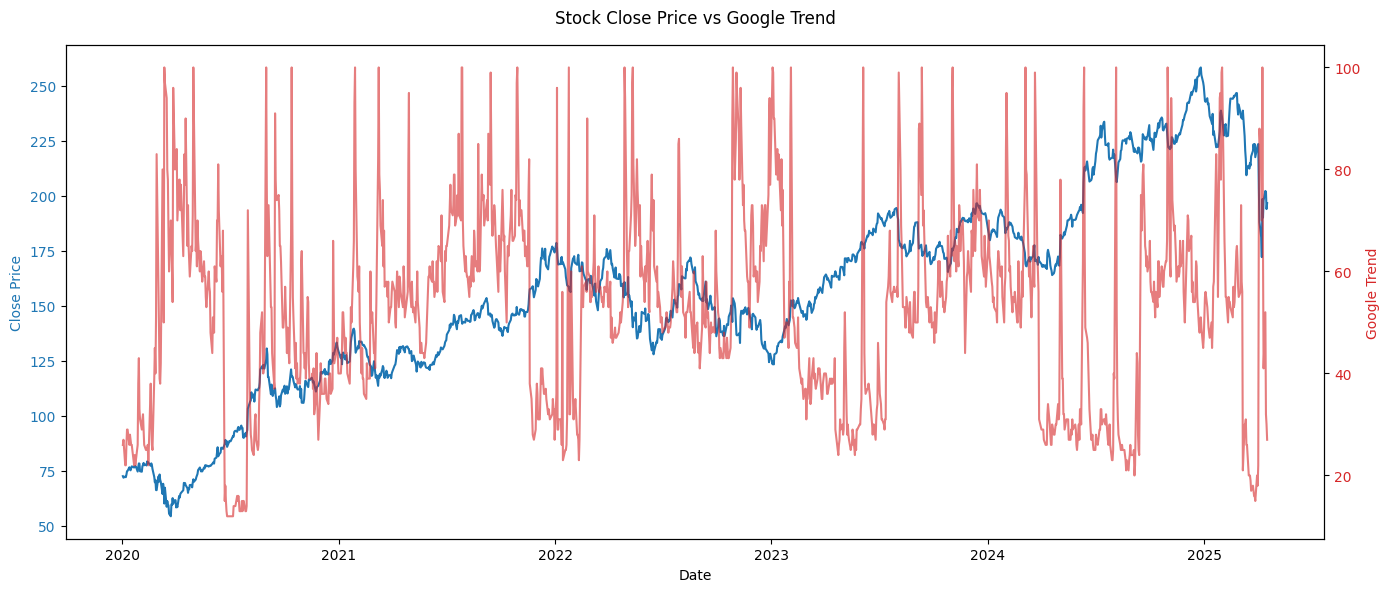

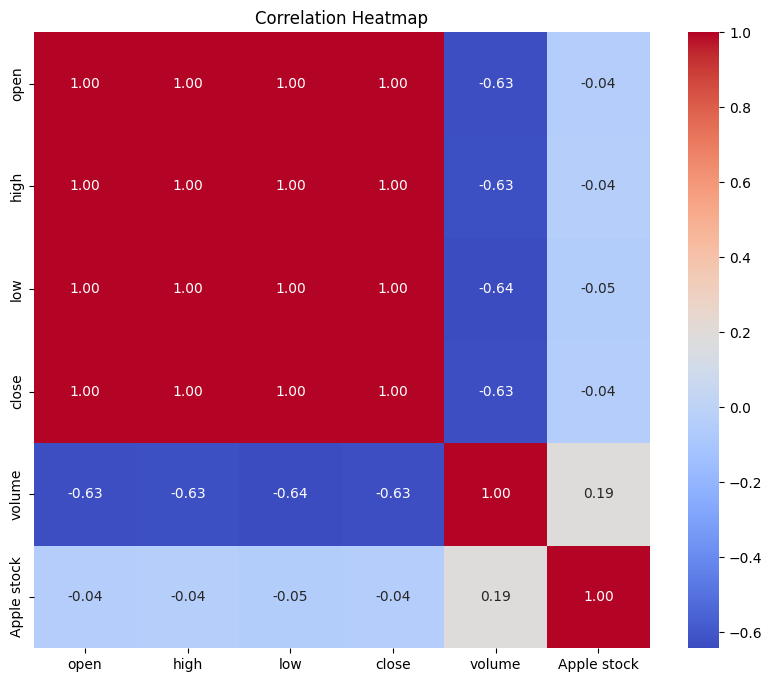

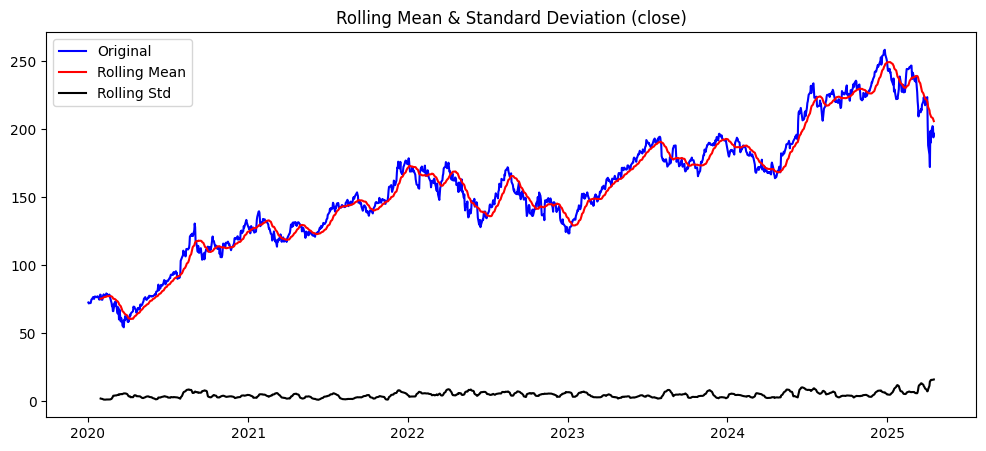

ADF Statistic: -1.7731499611853607
p-value: 0.39387109151456334
Critical Value (1%): -3.4352762901939395
Critical Value (5%): -2.863715568491867
Critical Value (10%): -2.567928279721861


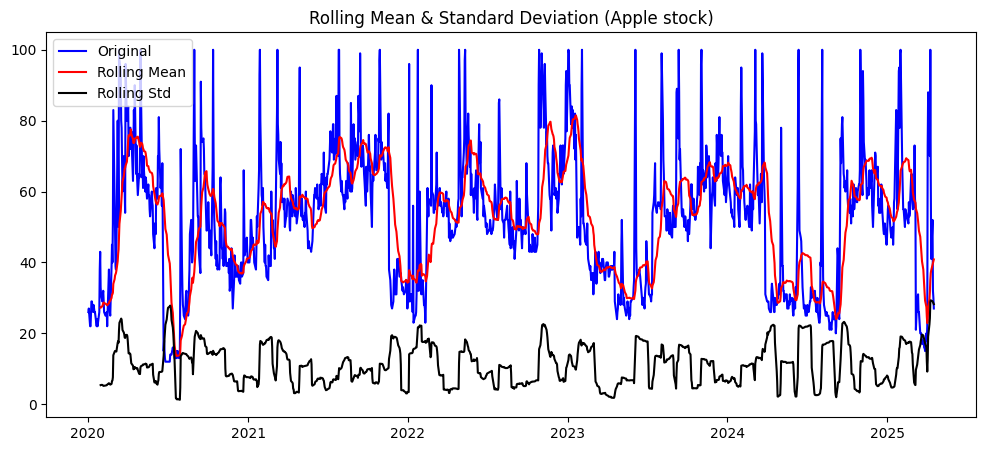

ADF Statistic: -7.505480661686742
p-value: 4.1456013570211395e-11
Critical Value (1%): -3.435287448902869
Critical Value (5%): -2.8637204923840334
Critical Value (10%): -2.5679309018875833

ADF Test Results - ADF Test - Close Price
ADF Statistic: -1.7731499611853607
p-value: 0.39387109151456334
# Lags Used: 0
# Observations Used: 1330
Series is not stationary (fail to reject H0)

ADF Test Results - ADF Test - Google Trend
ADF Statistic: -7.505480661686742
p-value: 4.1456013570211395e-11
# Lags Used: 3
# Observations Used: 1327
Series is stationary (reject H0)


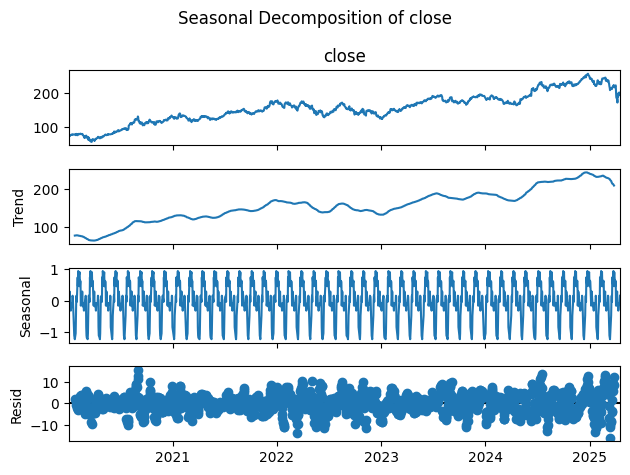

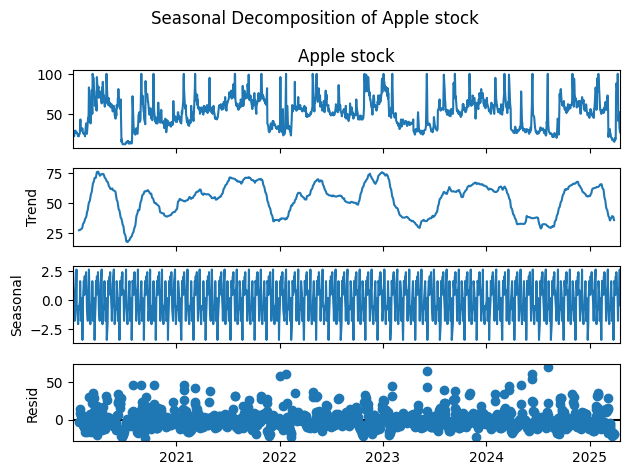

In [12]:
#@title fetch stock data and invoke plots
# ⚙️ Initialize the data collector
collector = MarketDataCollector()

# 📅 Define time range and keywords
ticker = "AAPL"
keyword = "Apple stock"
start_date = "2020-01-01"
end_date = "2025-04-20"

# Fetch and merge OHLC + Google Trend data
df = collector.fetch_and_merge_ohlc_trends(
    ticker=ticker,
    trend_keyword=keyword,
    start_date=start_date,
    end_date=end_date
)
# Trigger: Price and Google Trend together
plot_price_and_trend(df, price_col='close', trend_col='Apple stock')
# Trigger: Correlation matrix including Google Trends
plot_correlation_heatmap(df[['open', 'high', 'low', 'close', 'volume', 'Apple stock']])
# ADF with close
test_stationarity(df, col='close')
# ADF with Apple stock
test_stationarity(df, col='Apple stock')
# Trigger: ADF Test for stationarity on closing price
test_stationarity_with_title(df['close'], title='ADF Test - Close Price')
# Trigger: ADF Test for stationarity on Google Trends
test_stationarity_with_title(df['Apple stock'], title='ADF Test - Google Trend')
# Trigger: Decomposition of closing price
decompose_series(df, col='close', model='additive', freq=30)
# Optional: Decomposition of Google Trend
decompose_series(df, col='Apple stock', model='additive', freq=30)

## 📊 Enhanced EDA: Volatility, Distributions, and Lag Analysis

To deepen our understanding of the stock's behavior and potential predictability, we enhance our EDA with:

- **Volatility plots**: To observe fluctuations and risk behavior
- **Distribution plots**: To analyze returns and check for skew/kurtosis
- **Lag plots**: To evaluate autocorrelation and stationarity hints

These plots are crucial for assessing whether models like ARIMA or LSTM can capture temporal structure effectively.


In [13]:
def plot_volatility(df: pd.DataFrame, col: str = 'Close', window: int = 20) -> None:
    """
    Plots historical volatility (rolling standard deviation of returns).

    Parameters:
        df (pd.DataFrame): DataFrame with stock price data
        col (str): Column to compute returns from
        window (int): Rolling window for volatility estimation
    """
    returns = df[col].pct_change()
    volatility = returns.rolling(window=window).std()

    plt.figure(figsize=(12, 5))
    plt.plot(volatility, label=f'{window}-Day Rolling Volatility', color='orange')
    plt.title(f'Rolling Volatility of {col} Returns')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
def plot_return_distribution(df: pd.DataFrame, col: str = 'Close') -> None:
    """
    Plots the distribution of daily returns with KDE and normal overlay.

    Parameters:
        df (pd.DataFrame): DataFrame with stock prices
        col (str): Column to calculate returns from
    """
    returns = df[col].pct_change().dropna()

    plt.figure(figsize=(10, 5))
    sns.histplot(returns, bins=50, kde=True, color='skyblue')
    plt.axvline(returns.mean(), color='red', linestyle='--', label='Mean')
    plt.title(f'Distribution of Daily Returns ({col})')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
from pandas.plotting import lag_plot

def plot_lag(df: pd.DataFrame, col: str = 'Close', lag: int = 1) -> None:
    """
    Creates a lag plot to detect autocorrelation in a time series.

    Parameters:
        df (pd.DataFrame): DataFrame with price series
        col (str): Column to analyze
        lag (int): Number of lag periods
    """
    plt.figure(figsize=(6, 6))
    lag_plot(df[col], lag=lag)
    plt.title(f'Lag Plot (lag = {lag}) of {col}')
    plt.grid(True)
    plt.show()


In [16]:
def multi_lag_plots(df: pd.DataFrame, col: str = 'Close', lags: list = [1, 2, 3, 5, 10]) -> None:
    """
    Generate multiple lag plots to visualize autocorrelation over different lags.
    """
    n = len(lags)
    plt.figure(figsize=(14, 3 * n))
    for i, lag in enumerate(lags):
        plt.subplot(n, 1, i + 1)
        lag_plot(df[col], lag=lag)
        plt.title(f'Lag = {lag}')
        plt.grid(True)
    plt.tight_layout()
    plt.show()


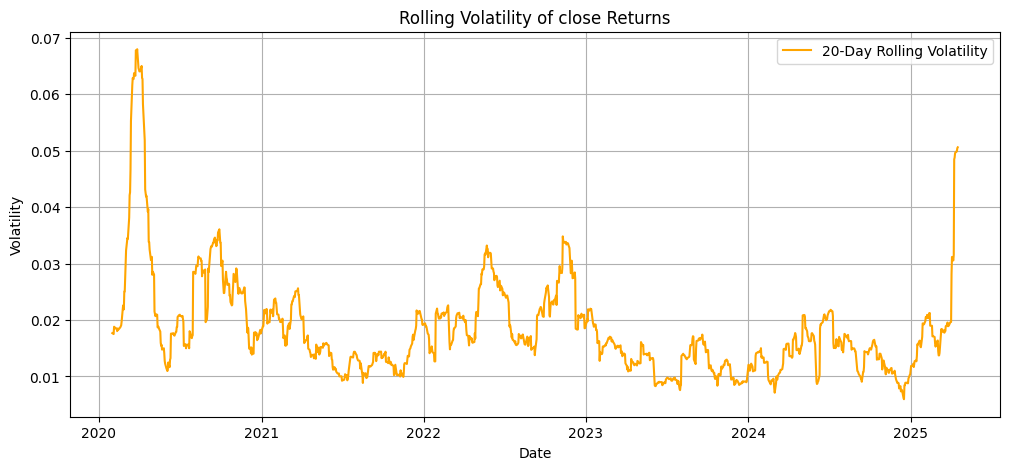

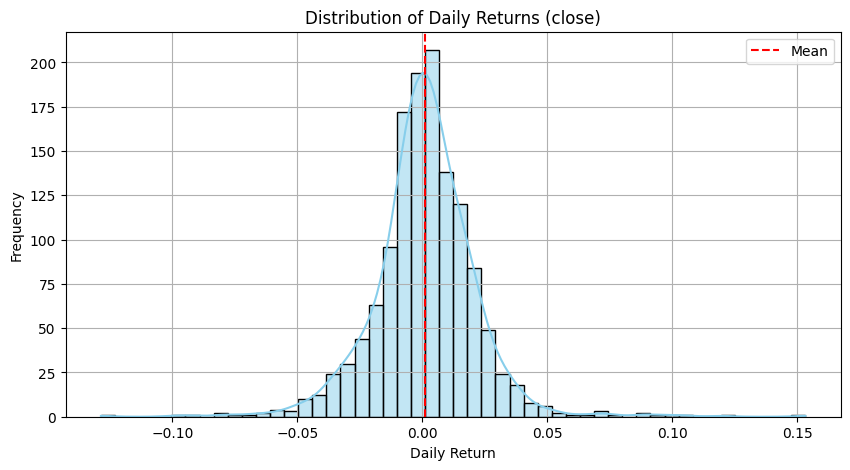

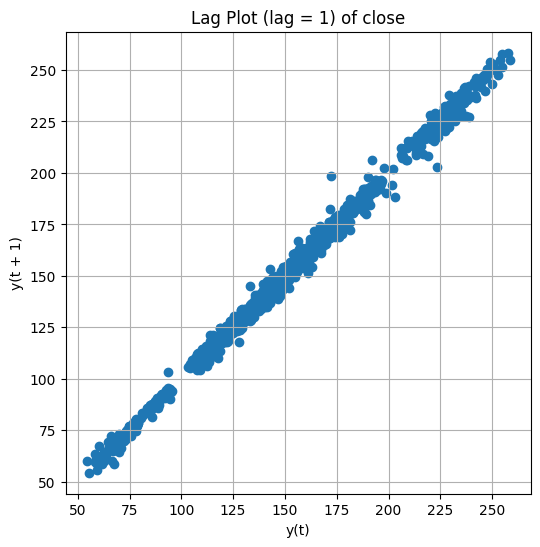

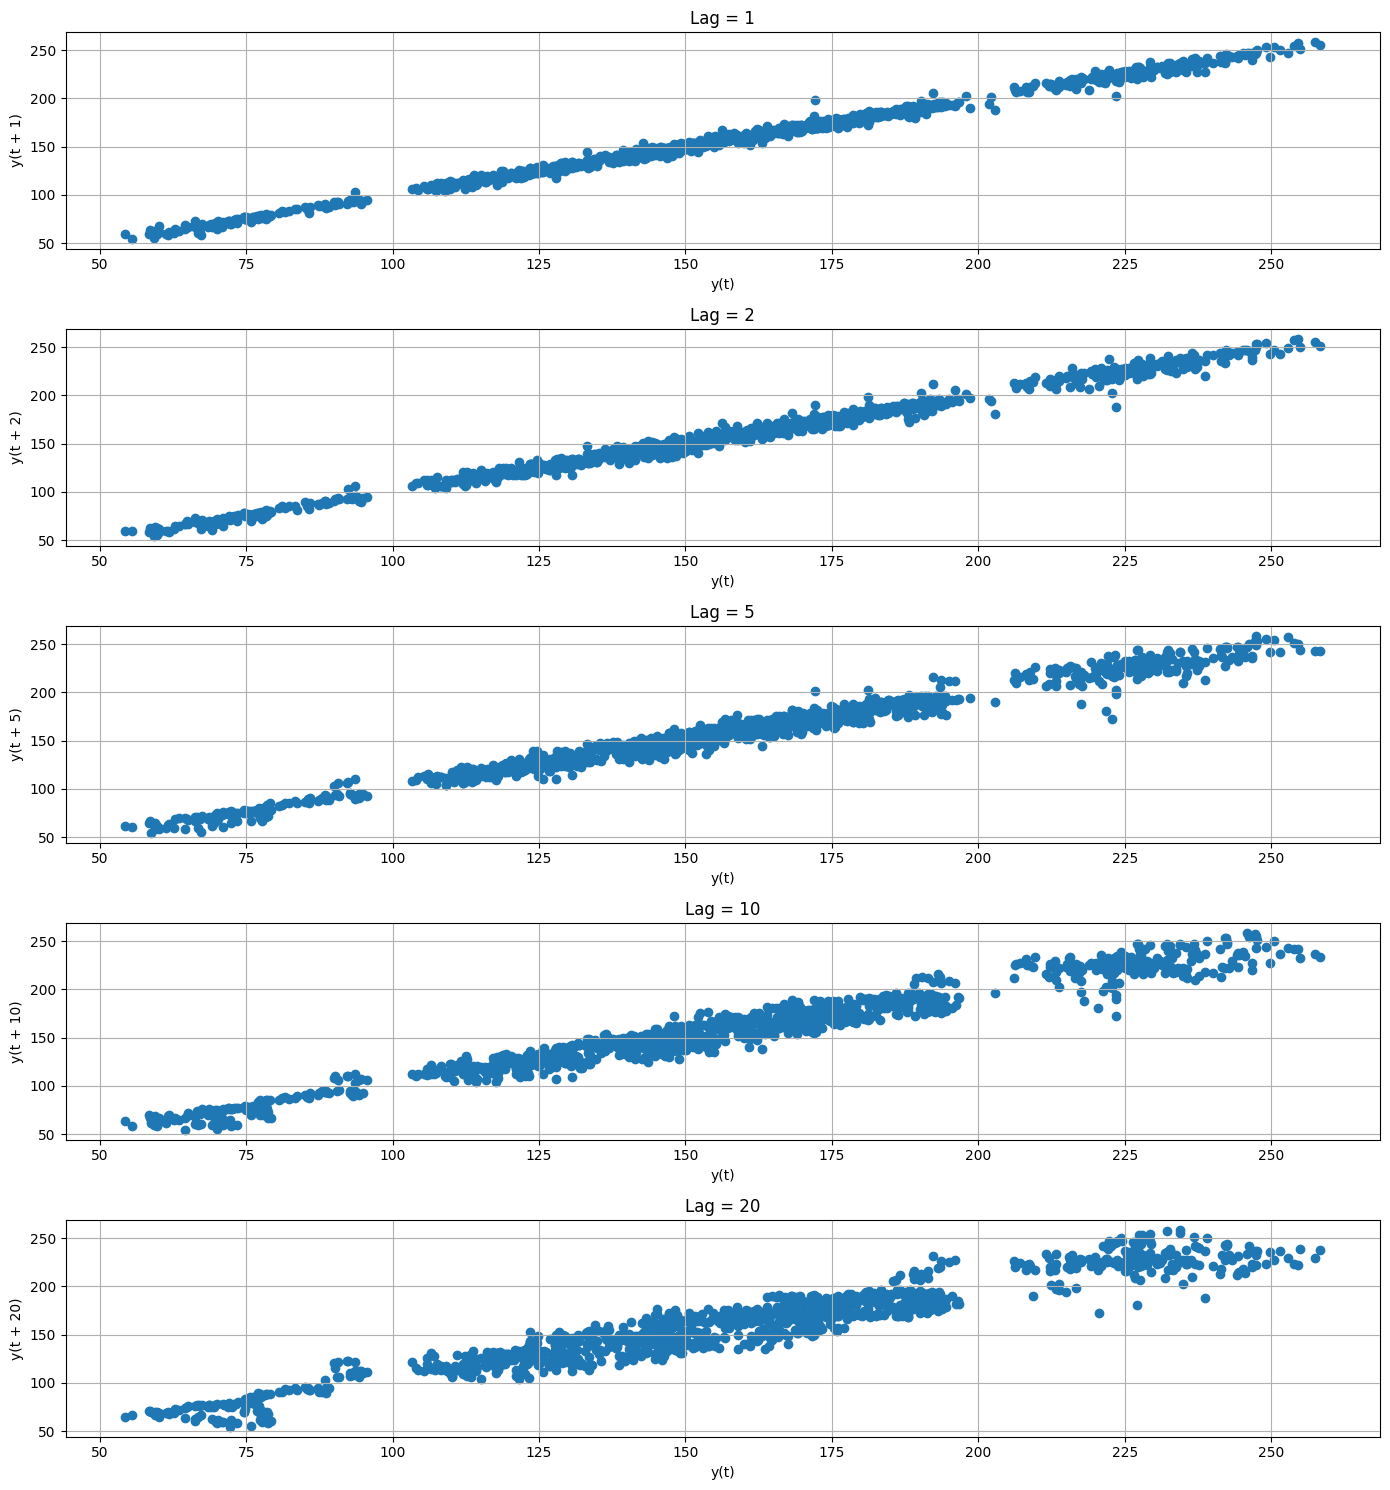

In [17]:
# Volatility Plot: Shows % daily returns
plot_volatility(df, col='close')

# Return Distribution: Histogram of daily returns
plot_return_distribution(df, col='close')

# Single Lag Plot: Price vs 1-day lag
plot_lag(df, col='close', lag=1)

# Multi Lag Plots: Visualize autocorrelation structure
multi_lag_plots(df, col='close', lags=[1, 2, 5, 10, 20])

# 🔢 5. Modeling with ARIMA

In this section, we build a classical ARIMA (AutoRegressive Integrated Moving Average) model to forecast stock prices.

Steps involved:
- Select the time series column to model (e.g., Close price)
- Check for stationarity and apply differencing if needed
- Choose appropriate (p, d, q) parameters using ACF/PACF and/or grid search
- Fit the ARIMA model on training data
- Forecast future values and evaluate accuracy (RMSE, MAE)


In [18]:
def train_test_split_series(df: pd.DataFrame, col: str = 'close', train_ratio: float = 0.8):
    """
    Splits a time series column into training and test sets.

    Parameters:
        df (pd.DataFrame): DataFrame with stock price
        col (str): Column to model
        train_ratio (float): Fraction of data to use for training

    Returns:
        pd.Series, pd.Series: train_series, test_series
    """
    series = df[col]
    train_size = int(len(series) * train_ratio)
    train, test = series[:train_size], series[train_size:]
    print(f"Training size: {len(train)} | Test size: {len(test)}")
    return train, test

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def fit_arima_and_forecast(train, test, order=(5, 1, 0)):
    """
    Fits ARIMA model and forecasts over test horizon.

    Parameters:
        train (pd.Series): Training time series
        test (pd.Series): Testing time series
        order (tuple): ARIMA (p,d,q) parameters

    Returns:
        forecast (np.array), model summary
    """
    print(f"Fitting ARIMA model with order {order}...")
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))
    forecast.index = test.index

    # Evaluation
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    print(f"\n📈 RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Actual', color='black')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title('ARIMA Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast, model_fit.summary()


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series: pd.Series, lags: int = 40):
    """
    Plots ACF and PACF to help choose ARIMA p, q parameters.

    Parameters:
        series (pd.Series): Time series (preferably stationary)
        lags (int): Number of lags to show
    """
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title("Autocorrelation (ACF)")

    plt.subplot(1, 2, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title("Partial Autocorrelation (PACF)")

    plt.tight_layout()
    plt.show()


Fetching OHLC data for AAPL from 2020-01-01 to 2025-04-19...


[*********************100%***********************]  1 of 1 completed


Raw OHLC columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
OHLC data shape: (1331, 5)
                  open        high         low       close     volume
Date                                                                 
2020-01-02   71.627084   72.681281   71.373211   72.620834  135480400
2020-01-03   71.847110   72.676439   71.689950   71.914810  146322800
2020-01-06   71.034702   72.526526   70.783241   72.487839  118387200
2020-01-07   72.497545   72.753839   71.926930   72.146957  108872000
2020-01-08   71.849518   73.609729   71.849518   73.307495  132079200
...                ...         ...         ...         ...        ...
2025-04-11  185.856281  199.278667  185.816325  197.890488   87435900
2025-04-14  211.163092  212.661128  200.896557  202.254776  101352900
2025-04-15  201.595643  203.243476  199.538343  201.875275   51343900
2025-04-16  198.100219  200.437151  192.118058  194.015579   59732400
2025-04-17  196.941744

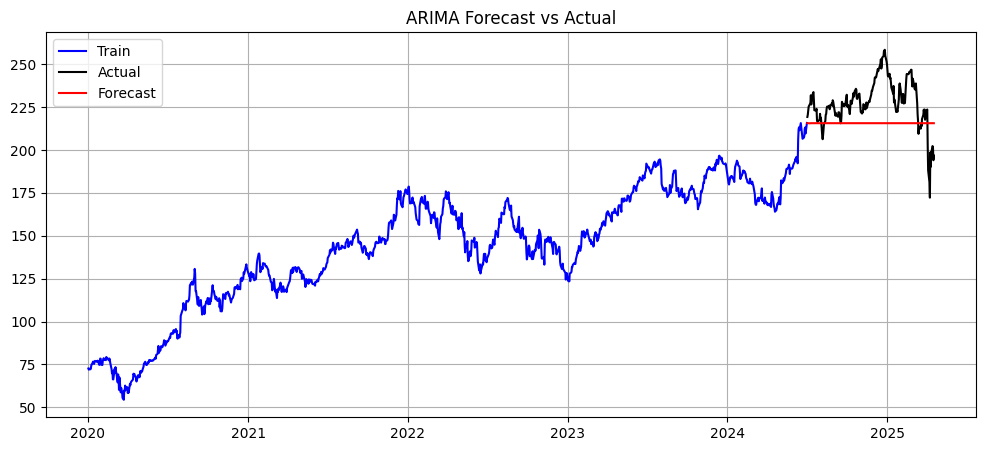

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1131
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2696.080
Date:                Sat, 24 May 2025   AIC                           5404.161
Time:                        21:12:07   BIC                           5434.341
Sample:                             0   HQIC                          5415.563
                               - 1131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0256      0.025     -1.023      0.306      -0.075       0.023
ar.L2         -0.0187      0.027     -0.685      0.493      -0.072       0.035
ar.L3         -0.0139      0.029     -0.478      0.6

In [21]:
# Example Workflow
# Download Data from Apple stock from 1st January 2024 to 19th April 2025 using MarketDataCollector class object
obj = MarketDataCollector()
df = obj.fetch_ohlc_data(ticker='AAPL', start_date='2020-01-01', end_date='2025-04-19')
train, test = train_test_split_series(df, col='close', train_ratio=0.85) # Changed 'Close' to 'close'

# Optional: plot_acf_pacf(train.diff().dropna()) to choose order
forecast, summary = fit_arima_and_forecast(train, test, order=(5, 1, 0))

# Display model summary
print(summary)

# 🤖 6. Modeling with LSTM

In this section, we build a Long Short-Term Memory (LSTM) neural network for time series forecasting. LSTM is particularly effective for learning long-term dependencies and patterns in sequential data like stock prices.

Steps involved:
- Create sequences of past time steps as input (X) and future price as target (y)
- Normalize data for neural network input
- Build and train the LSTM model using Keras
- Forecast stock prices and compare with actual values


In [22]:
def create_lstm_sequences(series: pd.Series, window_size: int = 60):
    """
    Converts a time series into supervised learning sequences for LSTM.

    Parameters:
        series (pd.Series): Univariate time series
        window_size (int): Number of time steps in the past to use

    Returns:
        X, y: numpy arrays for LSTM input and output
    """
    data = series.values
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])

    X = np.array(X)
    y = np.array(y)

    # Reshape for LSTM [samples, time_steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    print(f"Created sequences: {X.shape[0]} samples | Input shape: {X.shape}")
    return X, y

In [23]:
def build_and_train_lstm(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    """
    Builds and trains an LSTM model on the given sequences.

    Returns:
        model: Trained Keras model
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    return model, history

In [24]:
def predict_and_plot_lstm(model, X_val, y_val, scaler=None):
    """
    Makes predictions and plots them against the actual values.

    Parameters:
        model: Trained LSTM model
        X_val: Validation sequences
        y_val: True values
        scaler: If provided, inverse transforms predictions
    """
    predictions = model.predict(X_val)

    if scaler:
        predictions = scaler.inverse_transform(predictions)
        y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

    plt.figure(figsize=(12, 5))
    plt.plot(y_val, label='Actual Price', color='black')
    plt.plot(predictions, label='LSTM Predicted Price', color='green')
    plt.title('LSTM Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    print(f"📉 LSTM RMSE: {rmse:.4f} | MAE: {mae:.4f}")

In [25]:
def predict_and_plot_lstm(model, X_val, y_val, scaler=None):
    """
    Makes predictions and plots them against the actual values.

    Parameters:
        model: Trained LSTM model
        X_val: Validation sequences
        y_val: True values
        scaler: If provided, inverse transforms predictions
    """
    predictions = model.predict(X_val)

    if scaler:
        # Reshape predictions to have the same number of features as the scaler was trained on
        predictions = predictions.reshape(-1, 1)  # Reshape to (n_samples, 1)

        # Inverse transform predictions and true values using the original scaler
        predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros_like(predictions)], axis=1))[:, 0]  # Take the first column (close price)
        y_val = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros_like(y_val.reshape(-1, 1))], axis=1))[:, 0]  # Take the first column (close price)


    plt.figure(figsize=(12, 5))
    plt.plot(y_val, label='Actual Price', color='black')
    plt.plot(predictions, label='LSTM Predicted Price', color='green')
    plt.title('LSTM Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    print(f"📉 LSTM RMSE: {rmse:.4f} | MAE: {mae:.4f}")

[*********************100%***********************]  1 of 1 completed

Fetching OHLC data for AAPL from 2020-01-01 to 2025-04-19...
Raw OHLC columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
OHLC data shape: (1331, 5)
                  open        high         low       close     volume
Date                                                                 
2020-01-02   71.627084   72.681281   71.373211   72.620834  135480400
2020-01-03   71.847110   72.676439   71.689950   71.914810  146322800
2020-01-06   71.034702   72.526526   70.783241   72.487839  118387200
2020-01-07   72.497545   72.753839   71.926930   72.146957  108872000
2020-01-08   71.849518   73.609729   71.849518   73.307495  132079200
...                ...         ...         ...         ...        ...
2025-04-11  185.856281  199.278667  185.816325  197.890488   87435900
2025-04-14  211.163092  212.661128  200.896557  202.254776  101352900
2025-04-15  201.595643  203.243476  199.538343  201.875275   51343900
2025-04-16  198.100219  200.437

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0756 - val_loss: 0.0032
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - los

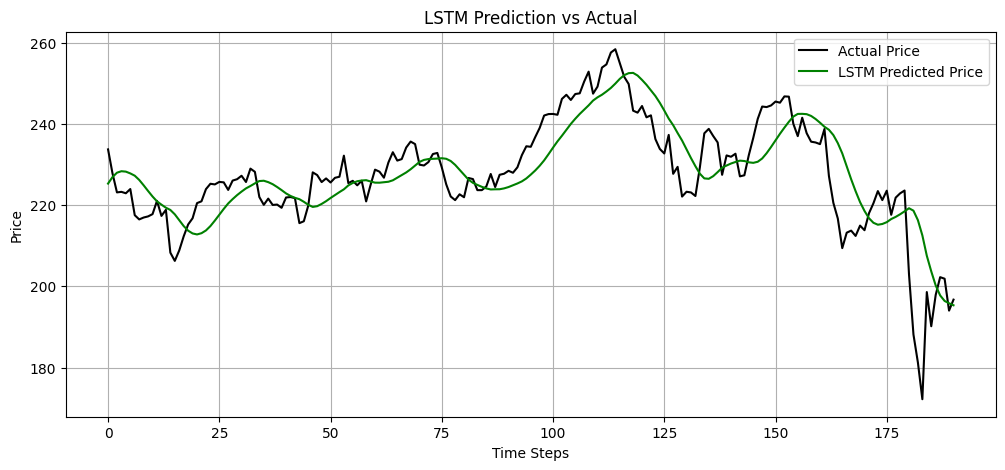

📉 LSTM RMSE: 8.2820 | MAE: 6.2849


In [26]:
# Download Data from Apple stock from 1st January 2020 to 19th April 2025 using MarketDataCollector class object
obj = MarketDataCollector()
df = obj.fetch_ohlc_data(ticker='AAPL', start_date='2020-01-01', end_date='2025-04-19')

# Normalize series
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(df[['close']])

# Create sequences
X, y = create_lstm_sequences(pd.Series(scaled_series.flatten()), window_size=60)

# Train/test split
split = int(0.85 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Train the LSTM
model, history = build_and_train_lstm(X_train, y_train, X_val, y_val, epochs=20)

# Predict and evaluate
predict_and_plot_lstm(model, X_val, y_val, scaler=scaler)

# 🧠 7. Multivariate LSTM with Google Trends Integration

In this section, we extend our LSTM model from univariate to multivariate by including Google Trends search interest as an additional input feature.

Steps involved:
- Normalize both Close price and Google Trend values
- Create supervised sequences for multivariate time series
- Train and evaluate the LSTM model using both features
- Compare performance with the univariate LSTM model


In [27]:
def create_multivariate_lstm_sequences(df: pd.DataFrame, feature_cols: list, target_col: str, window_size: int = 60):
    """
    Prepares multivariate LSTM sequences from multiple feature columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing features and target
        feature_cols (list): Column names to be used as input features
        target_col (str): Column to predict (e.g., 'Close')
        window_size (int): Number of time steps in the past to use

    Returns:
        X (np.array): 3D input tensor for LSTM
        y (np.array): Target values
        scaler (MinMaxScaler): Fitted scaler object
    """
    # Ensure target is not duplicated in feature columns
    feature_cols = list(set(feature_cols) - {target_col})

    # Final feature + target for scaling
    data = df[feature_cols + [target_col]].copy()

    # Scale features between 0 and 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=feature_cols + [target_col])

    X, y = [], []

    for i in range(window_size, len(scaled_df)):
        X.append(scaled_df[feature_cols].iloc[i-window_size:i].values)
        y.append(scaled_df[target_col].iloc[i])

    X = np.array(X)
    y = np.array(y)

    print(f"Multivariate sequences created: X shape = {X.shape}, y shape = {y.shape}")
    return X, y, scaler

[*********************100%***********************]  1 of 1 completed

Fetching OHLC data for AAPL from 2020-01-01 to 2025-04-20...
Raw OHLC columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
OHLC data shape: (1331, 5)
                  open        high         low       close     volume
Date                                                                 
2020-01-02   71.627092   72.681289   71.373218   72.620842  135480400
2020-01-03   71.847125   72.676454   71.689965   71.914825  146322800
2020-01-06   71.034717   72.526541   70.783256   72.487854  118387200
2020-01-07   72.497529   72.753823   71.926915   72.146942  108872000
2020-01-08   71.849533   73.609745   71.849533   73.307510  132079200
...                ...         ...         ...         ...        ...
2025-04-11  185.856281  199.278667  185.816325  197.890488   87435900
2025-04-14  211.163092  212.661128  200.896557  202.254776  101352900
2025-04-15  201.595643  203.243476  199.538343  201.875275   51343900
2025-04-16  198.100219  200.437

Multivariate sequences created: X shape = (1311, 20, 1), y shape = (1311,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1294 - val_loss: 0.1958
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0373 - val_loss: 0.1918
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0330 - val_loss: 0.1589
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0302 - val_loss: 0.1641
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0309 - val_loss: 0.1642
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0306 - val_loss: 0.1637
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0305 - val_loss: 0.1494
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0306 - val_loss: 0.2026
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0307 - val_loss: 0.1637
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0296 - val_loss: 0.1732
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0292 - val_loss: 0.1973
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss

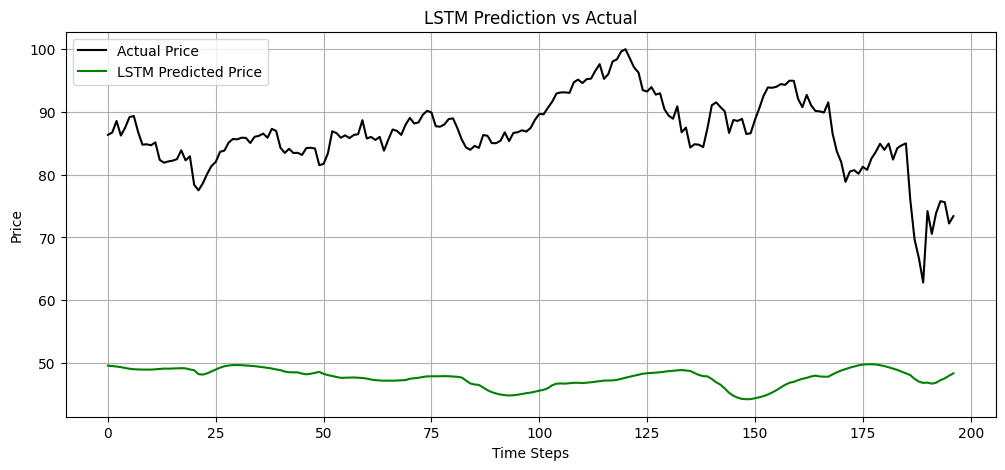

📉 LSTM RMSE: 39.5255 | MAE: 39.0252


In [28]:
# Initialize collector
collector = MarketDataCollector()
# Set parameters
ticker = "AAPL"
keyword = "Apple stock"
start = "2020-01-01"
end = "2025-04-20"

# Fetch merged data
df = collector.fetch_and_merge_ohlc_trends(ticker, keyword, start, end)

# Check column names
print(df.columns)

# Define features and target
features = ['close', 'Apple stock']
target = 'close'

# Create sequences
#X, y, scaler = create_multivariate_lstm_sequences(df, feature_cols=features, target_col=target, window_size=60)
X, y, scaler = create_multivariate_lstm_sequences(df, feature_cols=['close', 'Apple stock'], target_col='close', window_size=20)

# Train/test split
split = int(len(X) * 0.85)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Train model
model, history = build_and_train_lstm(X_train, y_train, X_val, y_val, epochs=20)

# Evaluate
predict_and_plot_lstm(model, X_val, y_val, scaler=scaler)